In [7]:
import sys
sys.path.append("../src")
sys.path.append("../data/embeddings")
import classifier
import svm_classifier
import debias
import gensim
import codecs
import json
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
import scipy
from scipy import linalg
from scipy.stats.stats import pearsonr
import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000

import warnings
warnings.filterwarnings("ignore")

In [8]:
def tsne_by_gender(vecs, labels, title, words = None):

  tsne = TSNE(n_components=2, random_state=0)
  vecs_2d = tsne.fit_transform(vecs)
  num_labels = len(set(labels.tolist()))

  names = ["class {}".format(i) for i in range(num_labels)]
  plt.figure(figsize=(6, 5))
  colors = 'r', 'b', 'orange'
  for i, c, label in zip(set(labels.tolist()), colors, names):
    print(len(vecs_2d[labels == i, 0]))
    plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                label=label, alpha = 0.1)
  plt.legend()
  plt.title(title)
  
  if words is not None:
        k = 60
        for i in range(k):
            
            j = np.random.choice(range(len(words)))
            label = labels[i]
            w = words[j]
            x,y = vecs_2d[i]
            plt.annotate(w , (x,y), size = 10, color = "black" if label == 1 else "black")
            
  plt.show()
  return vecs_2d

### Data loading & processing

In [9]:
def load_word_vectors(fname = "../data/embeddings/vecs.filtered.txt"):
    
    model = KeyedVectors.load_word2vec_format(fname, binary=False)
    vecs = model.vectors
    words = list(model.vocab.keys())
    return model, vecs, words

def project_on_gender_subspaces(gender_vector, model: Word2VecKeyedVectors, n = 2500):
    eps = 0.02
    
    group1 = model.similar_by_vector(gender_vector, topn = n, restrict_vocab=None)
    group2 = model.similar_by_vector(-gender_vector, topn = n, restrict_vocab=None)
    
    all_sims = model.similar_by_vector(gender_vector, topn = len(model.wv.vectors), restrict_vocab=None)
    eps = 0.06
    idx = [i for i in range(len(all_sims)) if abs(all_sims[i][1]) < eps]
    samp = set(np.random.choice(idx, size = n))
    neut = [s for i,s in enumerate(all_sims) if i in samp]
    return group1, group2, neut
    
    """
    all_sims =  model.similar_by_vector(gender_vector, topn = len(model.wv.vectors), restrict_vocab=None)
    pos,neg,neut = [], [], []
    for sim in all_sims:
        w,score = sim
        if score > 3*eps:
            pos.append(sim)
        elif score < - 0.5*3*eps:
            neg.append(sim)
        elif abs(score) < eps:
            neut.append(sim)

    group1 = [random.choice(pos) for i in range(n)]
    group2 = [random.choice(neg) for i in range(n)]
    group3 = [random.choice(neut) for i in range(n)]
    group1 = sorted(group1, key = lambda pair: -pair[1])
    group2 = sorted(group2, key = lambda pair: -pair[1])
    group3 = sorted(group3, key = lambda pair: -pair[1])
    
    return group1, group2, group3
    """
def get_vectors(word_list: list, model: Word2VecKeyedVectors):
    
    vecs = []
    for w in word_list:
        
        vecs.append(model[w])
    
    vecs = np.array(vecs)

    return vecs


def groups_by_neighbors(gender_vector, model: Word2VecKeyedVectors, n = 2500):

    biases = []
    words = list(model.wv.vocab.keys())
    for v,w in tqdm.tqdm(zip(model.wv.vectors, words), ascii = True, total = len(words)):
            
        bias =  get_bias_by_neighbors(model, v, gender_direction, topn = 100)
        biases.append((w, bias))
        #print((w,bias))
        
    pos,neg,neut = [], [], []
    
    eps = 0.25
    
    for word_and_bias in biases:
        w,bias = word_and_bias
        if bias > 0.5 + eps:
            pos.append(word_and_bias)
        elif bias < 0.5 - eps:
            neg.append(word_and_bias)
        elif abs(bias - 0.5) < eps/2:
            neut.append(word_and_bias)

    group1 = [random.choice(pos) for i in range(n)]
    group2 = [random.choice(neg) for i in range(n)]
    group3 = [random.choice(neut) for i in range(n)]
    group1 = sorted(group1, key = lambda pair: -pair[1])
    group2 = sorted(group2, key = lambda pair: -pair[1])
    group3 = sorted(group3, key = lambda pair: -pair[1])
    
    return group1, group2, group3        
        
    
    
def get_bias_by_neighbors(model, v, gender_direction, topn): 
    
    neighbors = model.similar_by_vector(v, topn = topn) 
    neighbors_words = [n for n, _ in neighbors]
    
    #bias = len([n for n in neighbors_words if n in gendered_words])
    bias = len([n for n in neighbors_words if model.cosine_similarities(model[n], [gender_direction])[0] > 0])
    bias /= (1.*topn)
    return bias


def save_in_word2vec_format(vecs: np.ndarray, words: np.ndarray, fname: str):


    with open(fname, "w", encoding = "utf-8") as f:

        f.write(str(len(vecs)) + " " + "300" + "\n")
        for i, (v,w) in tqdm.tqdm(enumerate(zip(vecs, words))):

            vec_as_str = " ".join([str(x) for x in v])
            f.write(w + " " + vec_as_str + "\n")

In [10]:
# 50k top vectors (without gender-typical words) - used for training

model, vecs, words = load_word_vectors(fname = "../data/embeddings/vecs.filtered.with_gendered.txt")

# only gendered vectors

model_gendered, _, _ = load_word_vectors(fname = "../data/embeddings/vecs.gendered.txt")

# all 300k vectors
model_all = KeyedVectors.load_word2vec_format("../data/embeddings/GoogleNews-vectors-negative300-SLIM.bin", binary=True)


gender_direction = model_gendered["he"] - model_gendered["she"]
#gender_direction = model_gendered["he"] + model_gendered["man"] + model_gendered["boy"] + model_gendered["him"] - (model_gendered["she"] + model_gendered["woman"] + model_gendered["girl"] + model_gendered["her"])
gender_unit_vec = gender_direction/np.linalg.norm(gender_direction)


masc_words_and_scores, fem_words_and_scores, neut_words_and_scores = project_on_gender_subspaces(gender_direction, model, n = 25000)
#masc_words_and_scores , fem_words_and_scores, neut_words_and_scores = groups_by_neighbors(gender_direction, model, n=5000)    

masc_words, masc_scores = list(zip(*masc_words_and_scores))
neut_words, neut_scores = list(zip(*neut_words_and_scores))
fem_words, fem_scores = list(zip(*fem_words_and_scores))
#fem_scores = [-x for x in fem_scores]
masc_vecs, fem_vecs = get_vectors(masc_words, model), get_vectors(fem_words, model)
neut_vecs = get_vectors(neut_words, model)

masc_words_and_scores_all, fem_words_and_scores_all, _ = project_on_gender_subspaces(gender_direction, model, n = 25000)
masc_words_all, _ = list(zip(*masc_words_and_scores))
fem_words_all, _ = list(zip(*fem_words_and_scores))
masc_vecs_all, fem_vecs_all = get_vectors(masc_words, model), get_vectors(fem_words, model)


#all_significantly_biased_words = masc_words + fem_words
#all_significantly_biased_vecs =  np.concatenate((masc_vecs, fem_vecs))
#all_significantly_biased_labels = np.concatenate((np.ones(fem_vecs.shape[0], dtype = int),
#                                                 np.zeros(masc_vecs.shape[0], dtype = int)))
#print(np.random.choice(masc_words, size = 75))
print("TOP MASC")
print(masc_words[:75])
print("LAST MASC")
print(masc_words[-75:])
print("-------------------------")
#print(np.random.choice(fem_words, size = 75))
print("TOP FEM")
print(fem_words[:75])
print("LAST FEM")
print(fem_words[-75:])
print("-------------------------")
#print(np.random.choice(neut_words, size = 75))
print(neut_words[:75])


TOP MASC
('he', 'himself', 'his', 'him', 'countryman', 'journeyman', 'boyhood', 'guy', 'beard', 'homeboy', 'He', 'hero', 'burly', 'goatee', 'rookie', 'affable', 'swashbuckling', 'maestro', 'scout', 'Irishman', 'jnr', 'buffoon', 'platooning', 'successor', 'madman', 'messiah', 'player', 'drafted', 'Englishman', 'legend', 'demigod', 'journeymen', 'playmaker', 'veteran', 'benching', 'players', 'hes', 'Groin', 'tradeable', 'snr', 'league', 'knucklehead', 'taciturn', 'bruiser', 'Kenny', 'mercurial', 'reinforcements', 'warhorse', 'superman', 'joker', 'platoon', 'countrymen', 'legendary', 'stocky', 'serviceable', 'tinkerer', 'Snr', 'statesman', 'guys', 'team', 'catchable', 'tactician', 'showman', 'buddy', 'hothead', 'unspectacular', 'phlegmatic', 'genius', 'savior', 'mustachioed', 'gamble', 'dapper', 'sideburns', 'Doubtful', 'everyman')
LAST MASC
('disheveled', 'Afro', 'applause', 'condensates', 'worriers', 'perchance', 'pl', 'Innovate', 'Allocation', 'overrode', 'burglary', 'replies', 'summar

In [11]:
print(np.mean(masc_scores))
print(np.mean(fem_scores))
print(np.mean(neut_scores))

0.07404961002618074
0.112371158118546
-0.0015458719793365514


### Perform train-dev-test split

In [41]:
X = np.concatenate((masc_vecs, fem_vecs, neut_vecs), axis = 0)
y_masc = np.ones(masc_vecs.shape[0], dtype = int)
y_fem = -np.ones(fem_vecs.shape[0], dtype = int)
y_neut = np.zeros(neut_vecs.shape[0], dtype = int)
#y = np.concatenate((masc_scores, fem_scores, neut_scores))#np.concatenate((y_masc, y_fem))
y = np.concatenate((y_masc, y_fem, y_neut))
X_train_dev, X_test, y_train_dev, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.4, random_state = 0)
X_train, X_dev, Y_train, Y_dev = sklearn.model_selection.train_test_split(X_train_dev, y_train_dev, test_size = 0.3, random_state = 0)
print("Train size: {}; Dev size: {}; Test size: {}".format(X_train.shape[0], X_dev.shape[0], X_test.shape[0]))

Train size: 29710; Dev size: 12734; Test size: 28297


### Debias

In [42]:
REGRESSION = False
NUM_CLASSES = 3
EPSILON = 0.015

classifier_class = svm_classifier.SVMClassifier
num_classifiers = 50
input_dim = 300
is_autoregressive = True
min_accuracy = 0.0 #((1./NUM_CLASSES) + EPSILON) if not REGRESSION else 0.07
add_noise = False
random_sample = False
siamese = False
siamese_dim = 1
REGULARIZATION = "l2"

P = debias.get_debiasing_projection(classifier_class, num_classifiers, input_dim, 
                                    is_autoregressive, min_accuracy, X_train, Y_train,
                                    X_dev, Y_dev, add_noise, random_sample, REGRESSION,
                                    siamese, REGULARIZATION)

Iteration 0, Accuracy: 0.8913931207790168
Iteration 1, Accuracy: 0.553635935291346
Iteration 2, Accuracy: 0.5014920684780901
Iteration 3, Accuracy: 0.44848437254594
Iteration 4, Accuracy: 0.41306737867127374
Iteration 5, Accuracy: 0.38817339406313806
Iteration 6, Accuracy: 0.3751374273598241
Iteration 7, Accuracy: 0.3725459400031412
Iteration 8, Accuracy: 0.36335793937490185
Iteration 9, Accuracy: 0.36186587089681166
Iteration 10, Accuracy: 0.3548767080257578
Iteration 11, Accuracy: 0.35157845138997956
Iteration 12, Accuracy: 0.351971100989477
Iteration 13, Accuracy: 0.3491440238730957
Iteration 14, Accuracy: 0.3490654939531962
Iteration 15, Accuracy: 0.3490654939531962
Iteration 16, Accuracy: 0.3490654939531962
Iteration 17, Accuracy: 0.3490654939531962
Iteration 18, Accuracy: 0.3490654939531962
Iteration 19, Accuracy: 0.3490654939531962
Iteration 20, Accuracy: 0.3490654939531962
Iteration 21, Accuracy: 0.3490654939531962
Iteration 22, Accuracy: 0.3490654939531962
Iteration 23, Accura

### Test the quality of the debiasing.

#### Perform t-sne

1943
2057


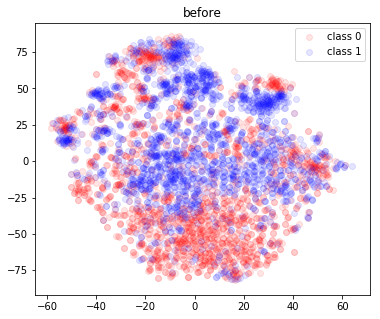

1943
2057


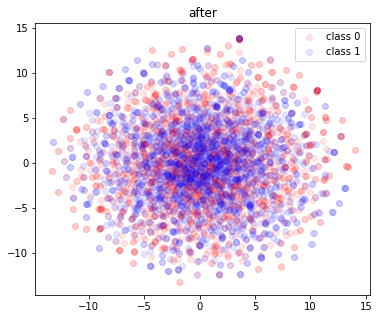

CALCULATING BIAS BY CLUSTERING (WITH K-MENAS)
NUM CLUSTERS = 2
Purity in original space: 0.04321369350445012
Purity after debiasing projection: 1.0647502703570682e-07
NUM CLUSTERS = 10
Purity in original space: 0.21681061228122153
Purity after debiasing projection: 0.0018710854767868498
NUM CLUSTERS = 25
Purity in original space: 0.2813450692082202
Purity after debiasing projection: 0.0038963231163605203
NUM CLUSTERS = 100
Purity in original space: 0.37202935167604795
Purity after debiasing projection: 0.03362670953603724


In [14]:
def perform_purity_test(vecs, k, labels_true):
        np.random.seed(0)
        clustering = sklearn.cluster.KMeans(n_clusters = k)
        clustering.fit(vecs)
        labels_pred = clustering.labels_
        score = sklearn.metrics.homogeneity_score(labels_true, labels_pred)
        return score
#print(Y_dev[:200])

def to_integer(arr, eps = 0.03):
    
    return np.array([1 if x > eps else (-1 if x < -eps else 0) for x in arr])
    
Y_dev = to_integer(Y_dev) #Y_dev > 0
Y_train = to_integer(Y_train)
X_dev = X_dev[Y_dev != 0]
X_train = X_train[Y_train != 0]
Y_dev = Y_dev[Y_dev != 0]
Y_train = Y_train[Y_train != 0]

M =  4000

tsne_by_gender(X_dev[:M], Y_dev[:M], title = "before")
X_dev_cleaned = X_dev.dot(P)
X_test_cleaned = X_test.dot(P)
X_trained_cleaned = X_train.dot(P)
#all_biased_cleaned = all_significantly_biased_vecs.dot(P)

tsne_projection = tsne_by_gender(X_dev_cleaned[:M], Y_dev[:M], title = "after")

#tsne_projection = tsne_by_gender(all_biased_cleaned, all_significantly_biased_labels,title = "after (all)", words = all_significantly_biased_words)

NUM_CLUSTERS = [2,10,25,100]

print("CALCULATING BIAS BY CLUSTERING (WITH K-MENAS)")
for num_clusters in NUM_CLUSTERS:
    print("NUM CLUSTERS = {}".format(num_clusters))
    purity_original = perform_purity_test(X_dev, k = num_clusters, labels_true = Y_dev)
    purity_after = perform_purity_test(X_dev_cleaned, k = num_clusters, labels_true = Y_dev)
    print("Purity in original space: {}".format(purity_original))
    print("Purity after debiasing projection: {}".format(purity_after))

#### Train a nonlinear classifier for gender prediction.

In [15]:
#nonlinear_clf = MLPClassifier(hidden_layer_sizes = 128, activation = "relu")
nonlinear_clf = SVC(kernel = "rbf")
#nonlinear_clf = SGDClassifier(loss = "modified_huber", verbose = 0, max_iter = 5000, fit_intercept = True, class_weight = "balanced", penalty = "l2")
print("Before:")
nonlinear_clf.fit(X_train, Y_train)
print(nonlinear_clf.score(X_dev, Y_dev))

print("After, rbf-svm:")
nonlinear_clf = SVC(kernel = "rbf")

nonlinear_clf.fit(X_trained_cleaned, Y_train)
print(nonlinear_clf.score(X_dev_cleaned, Y_dev))

print("After, mlp:")
nonlinear_clf = MLPClassifier(hidden_layer_sizes = 256, activation = "relu")

nonlinear_clf.fit(X_trained_cleaned, Y_train)
print(nonlinear_clf.score(X_dev_cleaned, Y_dev))

Before:
0.9851720703773376
After, rbf-svm:
0.4918667699457785
After, mlp:
0.6699125816089411


#### project on the gender direction

In [16]:
masc_vecs_cleaned = masc_vecs.dot(P)
fem_vecs_cleaned = fem_vecs.dot(P)

print("masc-bias-before: {}".format(masc_vecs.dot(gender_unit_vec).mean()))
print("masc-bias-after: {}".format(masc_vecs_cleaned.dot(gender_unit_vec.dot(P)).mean()))
print("fem-bias-before: {}".format(fem_vecs.dot(gender_unit_vec).mean()))
print("fem-bias-after: {}".format(fem_vecs_cleaned.dot(gender_unit_vec.dot(P)).mean()))      

masc-bias-before: 0.07404960691928864
masc-bias-after: -4.446495911629387e-05
fem-bias-before: -0.11237113922834396
fem-bias-after: -7.978320325105411e-05


#### calculate the similarity matrix before and after

In [17]:

def get_distance_matrix(vecs: np.ndarray):

  distances = sklearn.metrics.pairwise_distances(vecs, vecs, metric="cosine")
  return distances

def plot_distance(distance_before, distance_after):

    idx = distance_before < 0.75 # we are only interested in the relatively close words

    distance_before = distance_before.copy()[idx]
    distance_after = distance_after.copy()[idx]
    
    chosen = np.random.rand(len(distance_before)) < 0.01
    before = distance_before[chosen]
    after = distance_after[chosen]
    plt.plot(before, after, linestyle="None", marker = "*", alpha = 0.1)
    plt.xlabel("distnace before")
    plt.ylabel("distance after")

    plt.show()
    print("Correlation: {}".format(pearsonr(before, after)[0]))
    
def plot_similarity_change_vs_original_bias(bias_before, distance_before, distance_after):

    K = 50
    most_similar_idx_before = distance_before.argsort(axis = 0)[:K].T
    most_similar_idx_after = distance_after.argsort(axis = 0)[:K].T
    data = []
    
    for i, (bias, dis_before, dis_after) in enumerate(tqdm.tqdm(zip(bias_before, distance_before, distance_after), ascii = True, total = len(bias_before))):
        
        idx_before = set(most_similar_idx_before[i].tolist())
        idx_after = set(most_similar_idx_after[i].tolist())
        intersection = (most_similar_idx_before[i] == most_similar_idx_after[i]).sum() 
        intersection = idx_before.intersection(idx_after)
        data.append((abs(bias), 1 - len(intersection)/K))
        #data.append((abs(bias), 1 - intersection/K))
        
    plt.xlabel("change in similarity (% of of top-{}-similar that changed)".format(K))
    plt.ylabel("bias before")
    biases, sims = zip(*data)    
    plt.plot(sims, biases, linestyle="None", marker = "*", alpha = 0.1)

    plt.show()
    print("Correlation: {}".format(pearsonr(biases, sims)[0]))

#### Plot similarity before vs. similarity after, and change of similarity vs. bias before

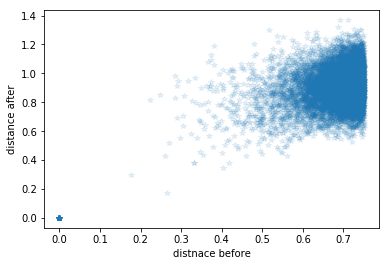

Correlation: 0.5139144018583972


100%|##########| 8025/8025 [00:00<00:00, 70025.19it/s]


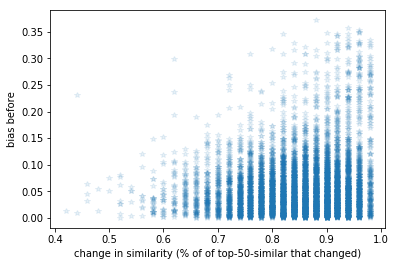

Correlation: 0.14945889429245865


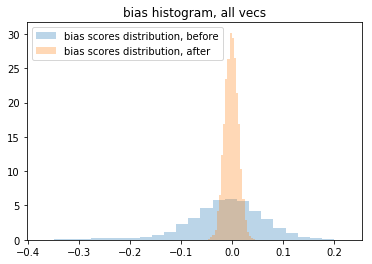

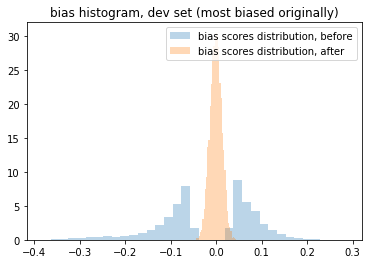

In [18]:
prop = 0.08
idx = np.random.rand(vecs.shape[0]) < prop
vecs_sample = vecs[idx]
words_sample = np.array(words, dtype = "object")[idx]

vecs_sample_cleaned = vecs_sample.dot(P)

distance_before = get_distance_matrix(vecs_sample)
distance_after = get_distance_matrix(vecs_sample_cleaned)

gender_unit_vec = gender_direction/np.linalg.norm(gender_direction)
sample_normalized = vecs_sample/np.linalg.norm(vecs_sample, axis = 1, keepdims = True)
sample_cleaned_normalized = vecs_sample_cleaned/np.linalg.norm(vecs_sample_cleaned, axis = 1, keepdims = True)

bias_before = sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(gender_direction, 0), vecs_sample)[0] #sample_normalized.dot(gender_unit_vec)
bias_after = sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(gender_direction, 0), vecs_sample_cleaned)[0] #sample_normalized.dot(gender_unit_vec)

plot_distance(distance_before.reshape(-1), distance_after.reshape(-1))
plot_similarity_change_vs_original_bias(bias_before, distance_before, distance_after)

# plot bias histograms before and after

# all vecs

plt.hist(bias_before, bins = 25, label = "bias scores distribution, before", alpha = 0.3, density = True)
plt.hist(bias_after, bins = 25, label = "bias scores distribution, after", alpha = 0.3, density = True)
plt.legend()
plt.title("bias histogram, all vecs")
plt.show()

# most originally biased (dev set)

bias_before_dev = sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(gender_direction, 0), X_dev)[0]
bias_after_dev = sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(gender_direction, 0), X_dev.dot(P))[0]

plt.hist(bias_before_dev, bins = 35, label = "bias scores distribution, before", alpha = 0.3, density = True)
plt.hist(bias_after_dev, bins = 35, label = "bias scores distribution, after", alpha = 0.3, density = True)
plt.legend()
plt.title("bias histogram, dev set (most biased originally)")
plt.show()


In [19]:
vecs_cleaned = vecs.dot(P)
save_in_word2vec_format(vecs_cleaned, words, "../data/embeddings/vecs.50k.cleaned.txt")
model_cleaned, _, _ = load_word_vectors(fname = "../data/embeddings/vecs.50k.cleaned.txt")

all_cleaned = model_all.wv.vectors.dot(P)
#print(all_cleaned.shape, len(list(model_all.wv.vocab.keys())))
save_in_word2vec_format(all_cleaned, list(model_all.wv.vocab.keys()), "../data/embeddings/all.cleaned.txt")
model_all_cleaned, _, _ = load_word_vectors(fname = "../data/embeddings/all.cleaned.txt")


100000it [00:25, 3969.57it/s]
299567it [01:18, 3811.45it/s]


#### calcualte the similarity of female-stereotyped words to 'girlish', before and after

In [33]:

w = "girlish"
k = 200

random_fem_words = np.random.choice(fem_words, size = k)
sim_to_girlish_before = [model.similarity(w,w2) for w2 in random_fem_words]
sim_to_girlish_after = [model_cleaned.similarity(w,w2) for w2 in random_fem_words]

print("Similarity of female-stereotyped words to 'girlish' before: {}; similarity after: {}".format(np.mean(sim_to_girlish_before), np.mean(sim_to_girlish_after)))


Similarity of female-stereotyped words to 'girlish' before: 0.11391372978687286; similarity after: 0.007808025926351547


### Calcualte bias-by-clustering

In [34]:
def numerical_bias_by_clustering(model_before, model_after, masc_words, fem_words, k):
    
    scores_before, scores_after = [], []
    all_biased = masc_words.union(fem_words)
    
    for w in all_biased:
        
        most_similar_before = model_before.most_similar(w, topn = k)
        most_similar_before, _ = zip(*most_similar_before)

        most_similar_after = model_after.most_similar(w, topn = k)
        most_similar_after, _ = zip(*most_similar_after)
        
        neighbors_biased_before = len([w for w in most_similar_before if w in all_biased])
        neighbors_biased_after = len([w for w in most_similar_after if w in all_biased])
        scores_before.append(neighbors_biased_before)
        scores_after.append(neighbors_biased_after)
    print("avg. number of biased neighbors before: {}; after: {}".format(np.mean(scores_before), np.mean(scores_after)))
    
    
    
    

In [35]:
#numerical_bias_by_clustering(model, model_cleaned, set(masc_words), set(fem_words), k = 1000)

#### print the most similar words to random words before and after (to make sure we didn't damage the space too much)

In [40]:
words_chosen = np.random.choice(words , size = 100)

words_chosen = ["child", "nurse"]
topn = 10

for w in words_chosen:
    words_and_sims_before = model.most_similar(w, topn = topn)
    words__and_sims_after = model_cleaned.most_similar(w, topn = topn)
    words_before, _ = zip(*words_and_sims_before)
    words_after, _ = zip(*words__and_sims_after)
    print("w: {}\n most-similar-before: {}\n most-similar-after: {}".format(w,words_before, words_after))
    print("----------------------------------")

w: child
 most-similar-before: ('children', 'infant', 'toddler', 'baby', 'newborn', 'Child', 'preschooler', 'grandchild', 'mother', 'parents')
 most-similar-after: ('Child', 'children', 'infant', 'Shaftsbury', 'girl', 'boy', 'minors', 'Winchendon', 'Paquette', 'visuals')
----------------------------------
w: nurse
 most-similar-before: ('nurses', 'midwife', 'Nurse', 'nursing', 'doctor', 'medic', 'anesthetist', 'pharmacist', 'paramedic', 'receptionist')
 most-similar-after: ('nurses', 'porter', 'midwife', 'nursed', 'medic', 'paramedic', 'Seals', 'patient', 'Nurse', 'dietitian')
----------------------------------


### bias by profession experiment

In [22]:
def get_bias_by_neighbors(model, model_cleaned, gendered_words, v, gender_direction): 
    
    neighbors = model_cleaned.similar_by_vector(v, topn=100) 
    neighbors_words = [n for n, _ in neighbors]
    
    #bias = len([n for n in neighbors_words if n in gendered_words])
    bias = len([n for n in neighbors_words if model.cosine_similarities(model[n], [gender_direction])[0] > 0])
    return bias

def bias_by_profession(model, model_cleaned, gender_direction, P, masc_words):
    
    with codecs.open("../data/lists/professions.json") as f:
        professions_and_scores = json.load(f)

    professions = [p[0] for p in professions_and_scores]
    #print(professions)
    professions = list(filter(lambda p: p in model.wv, professions))
    vecs = np.array([model[p] for p in professions])
    vecs_cleaned = vecs.dot(P)
    bias_vals = np.array([model.cosine_similarities(gender_direction,vecs)])[0]
    #bias_vals_after = np.array([model.cosine_similarities(gender_direction,vecs_cleaned)])[0]
    bias_by_neighbors_after = np.array([get_bias_by_neighbors(model, model_cleaned, masc_words, v, gender_direction) for v in vecs_cleaned])
    bias_by_neighbors_before = np.array([get_bias_by_neighbors(model, model, masc_words, v, gender_direction) for v in vecs])

    #plt.ylim([np.min(bias_vals), np.max(bias_vals)])
    plt.plot(bias_vals, bias_by_neighbors_after, marker = "o", linestyle = "none", color = "red", label = "after", alpha = 0.25)
    plt.plot(bias_vals, bias_by_neighbors_before, marker = "o", linestyle = "none", color = "blue", label = "before", alpha = 0.25)
    
    word_idx_high = np.argsort(bias_vals)[:4] 
    word_idx_low = np.argsort(bias_vals)[-4:]
    word_idx_middle_low = np.argsort(bias_vals)[-55:-51]
    word_idx_middle_high = np.argsort(bias_vals)[51:55]
    words_biased_fem = [professions[i] for i in word_idx_high]
    words_biased_masc = [professions[i] for i in word_idx_low]
    mid_low = [professions[i] for i in word_idx_middle_low]
    mid_high = [professions[i] for i in word_idx_middle_high]
    words = words_biased_masc + words_biased_fem + mid_low + mid_high
    
    for w in words:
        i = professions.index(w)
        x1,y1 = bias_vals[i],bias_by_neighbors_after[i]
        plt.annotate(w , (x1,y1), size = 8, color = "red")
        x2,y2 = bias_vals[i],bias_by_neighbors_before[i]
        plt.annotate(w, (x2,y2), size = 8, color = "blue")
        #plt.arrow(x2,y2,x1-x2,y1-y2, width = 0.0005)
        
    plt.legend()
    plt.xlabel("bias-by-PROJECTION of the professions before")
    plt.ylabel("bias-by-NEIGHBORS")
    plt.title("projection bias before vs. neighbors bias before/after \n(# neighbors closer to 'she' then 'he')")
    plt.show()
    
    print("Correlation before: {}, p-value: {}".format(*pearsonr(bias_vals, bias_by_neighbors_before)))
    print("Correlation after: {}, p-value: {}".format(*pearsonr(bias_vals, bias_by_neighbors_after)))

        

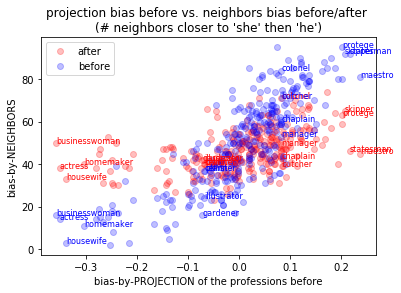

Correlation before: 0.8079783199359168, p-value: 2.3521175615032235e-68
Correlation after: 0.47979966699532095, p-value: 3.6827986054718495e-18


In [23]:
bias_by_profession(model, model_cleaned, gender_direction, P, fem_words_all)

In [24]:
"""
for i, (w,v,l) in enumerate(zip(all_significantly_biased_words,all_biased_cleaned,
                               all_significantly_biased_labels)):
    
    neighbors = model_cleaned.similar_by_vector(v, topn = 6, restrict_vocab=None)[1:]
    print(w, neighbors)
    print("===========================================")
 """

'\nfor i, (w,v,l) in enumerate(zip(all_significantly_biased_words,all_biased_cleaned,\n                               all_significantly_biased_labels)):\n    \n    neighbors = model_cleaned.similar_by_vector(v, topn = 6, restrict_vocab=None)[1:]\n    print(w, neighbors)\n    print("===========================================")\n '

### word association tests

In [25]:
# Auxiliary functions for experiments by Caliskan et al.

import scipy
import scipy.misc as misc
import itertools


def s_word(w, A, B, model, all_s_words):
    
    if w in all_s_words:
        return all_s_words[w]
    
    mean_a = []
    mean_b = []
    
    for a in A:
        mean_a.append(model.similarity(w,a))
    for b in B:
        mean_b.append(model.similarity(w,b))
        
    mean_a = sum(mean_a)/float(len(mean_a))
    mean_b = sum(mean_b)/float(len(mean_b))
    
    all_s_words[w] = mean_a - mean_b

    return all_s_words[w]


def s_group(X, Y, A, B, model, all_s_words):
    
    total = 0
    for x in X:
        x_sim = s_word(x, A, B, model, all_s_words)
        total += x_sim
    for y in Y:
        y_sim =  s_word(y, A, B, model, all_s_words)
        total -= y_sim
    
    #print(x_sim, y_sim)
        
    return total


def p_value_exhust(X, Y, A, B, model):
    
    if len(X) > 10:
        print ('might take too long, use sampled version: p_value')
        return
    
    assert(len(X) == len(Y))
    
    all_s_words = {}
    s_orig = s_group(X, Y, A, B, model, all_s_words)
    #print("s-orig: {}".format(s_orig))
    
    union = set(X+Y)
    subset_size = int(len(union)/2)
    
    larger = 0
    total = 0
    #all_subs = set(itertools.combinations(union, subset_size))
    #print(all_subs)
    for subset in tqdm.tqdm(set(itertools.combinations(union, subset_size))):
        total += 1
        Xi = list(set(subset))
        Yi = list(union - set(subset))
        if s_group(Xi, Yi, A, B, model, all_s_words) > s_orig:
            larger += 1
    #print ('num of samples', total)
    return larger/float(total)


def p_value_sample(X, Y, A, B, model):
    
    random.seed(10)
    np.random.seed(10)
    all_s_words = {}
    
    assert(len(X) == len(Y))
    length = len(X)
    
    s_orig = s_group(X, Y, A, B, model, all_s_words) 
    
    num_of_samples = min(10000, int(scipy.special.comb(length*2,length)*100))
    print ('num of samples', num_of_samples)
    larger = 0
    for i in range(num_of_samples):
        permute = np.random.permutation(X+Y)
        Xi = permute[:length]
        Yi = permute[length:]
        if s_group(Xi, Yi, A, B, model, all_s_words) > s_orig:
            larger += 1
    
    return larger/float(num_of_samples)

In [26]:
# Experiment 1

A = ['John', 'Paul', 'Mike', 'Kevin', 'Steve', 'Greg', 'Jeff', 'Bill']
B = ['Amy', 'Joan', 'Lisa', 'Sarah', 'Diana', 'Kate', 'Ann', 'Donna']
C = ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
D = ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']

print (p_value_exhust(A, B, C, D, model_all_cleaned))

# Experiment 2

E = ['math', 'algebra', 'geometry', 'calculus', 'equations', 'computation', 'numbers', 'addition']
F = ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture']

print (p_value_exhust(A, B, E, F, model_all_cleaned))


# Experiment 3

G = ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment', 'astronomy']
H = ['poetry', 'art', 'shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']

print (p_value_exhust(A, B, G, H, model_all_cleaned))

100%|██████████| 12870/12870 [00:00<00:00, 187637.54it/s]

0.039316239316239315
0.9970473970473971
0.9561771561771562


In [42]:
print(np.isclose(P.dot(P), P))

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [43]:
    print(list(zip(P[0], P.dot(P)[0]))[:10])   

[(0.4903561375231828, 0.39871727693622067), (0.027822499511602723, 0.014881996318084754), (-0.036007629502665436, -0.043810547925549254), (0.019629503222897277, 0.02571476373956777), (0.04807245394137438, 0.041715140861740024), (0.014136260282759196, 0.008874099950283638), (0.03398926326295127, 0.03014880437387118), (0.0193607230502056, 0.020036204856996625), (-0.025386464908855065, -0.02426240349603221), (0.021356417806766746, 0.012045566106173909)]
